In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error
from datetime import datetime
from keras.callbacks import EarlyStopping, ModelCheckpoint
import math
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import joblib


In [ ]:
# Xác định ký hiệu mã cổ phiếu và phạm vi ngày
stock_symbol = "ETH-USD"
end_date = datetime.today().strftime('%Y-%m-%d')  # Lấy ngày hiện tại

# Lấy dữ liệu lịch sử giá Ethereum
ETH = yf.download(stock_symbol, end=end_date)
ETH

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-11-09,308.644989,329.451996,307.056000,320.884003,320.884003,893249984
2017-11-10,320.670990,324.717987,294.541992,299.252991,299.252991,885985984
2017-11-11,298.585999,319.453003,298.191986,314.681000,314.681000,842300992
2017-11-12,314.690002,319.153015,298.513000,307.907990,307.907990,1613479936
2017-11-13,307.024994,328.415009,307.024994,316.716003,316.716003,1041889984
...,...,...,...,...,...,...
2024-03-08,3874.830811,3998.826416,3828.363281,3892.061035,3892.061035,26135487051
2024-03-09,3892.119141,3950.396484,3880.658936,3915.418945,3915.418945,11926623780
2024-03-10,3915.590576,3968.723633,3800.564453,3881.193115,3881.193115,15783924355


In [ ]:
data = ETH[['Close']]
data

,Close
Date,
2017-11-09,320.884003
2017-11-10,299.252991
2017-11-11,314.681000
2017-11-12,307.907990
2017-11-13,316.716003
...,...
2024-03-08,3892.061035
2024-03-09,3915.418945
2024-03-10,3881.193115


In [ ]:
#xác định kiểu dữ liệu
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2316 entries, 2017-11-09 to 2024-03-12
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   2316 non-null   float64
dtypes: float64(1)
memory usage: 36.2 KB


In [ ]:
#kích thước dữ liệu
data.shape

(2316, 1)

In [ ]:
#mô tả bộ dữ liệu
data.describe()

,Close
count,2316.000000
mean,1285.214700
std,1135.279191
min,84.308296
25%,235.700298
50%,1119.940491
75%,1899.933502
max,4812.087402


In [ ]:
# biểu đồ close price ETH
fig = px.line(data, x=ETH.index, y='Close', title='Biểu đồ giá đóng cửa ETH qua thời gian')
fig.update_yaxes(title_text='Close Price USD ($)')
fig.update_xaxes(title_text='Date')

# Hiển thị biểu đồ
fig.show()

In [ ]:
def test_stationarity(timeseries):

    # Xác định số liệu thống kê lăn
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    # Tạo biểu đồ
    fig = go.Figure()

    # Thêm dữ liệu gốc
    fig.add_trace(go.Scatter(x=timeseries.index, y=timeseries.values, mode='lines', name='Original'))

    # Thêm dữ liệu trung bình lăn
    fig.add_trace(go.Scatter(x=rolmean.index, y=rolmean.values, mode='lines', name='Rolling Mean', line=dict(color='red')))

    # Thêm dữ liệu độ lệch chuẩn lăn
    fig.add_trace(go.Scatter(x=rolstd.index, y=rolstd.values, mode='lines', name='Rolling Std', line=dict(color='black')))

    # Thiết lập tiêu đề và nhãn
    fig.update_layout(title='Giá trị trung bình lăn và độ lệch chuẩn',
                      xaxis_title='Thời gian',
                      yaxis_title='Giá trị',
                      legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.01))

    fig.show()

    print("Results of Dickey-Fuller Test")
    adft = adfuller(timeseries, autolag='AIC')
    # đầu ra cho dft sẽ cung cấp cho chúng ta mà không cần xác định giá trị là gì.
    # do đó ta viết thủ công những giá trị nào nó giải thích bằng vòng lặp for
    output = pd.Series(adft[0:4], index=['Test Statistics', 'p-value', 'No. of lags used', 'Number of observations used'])
    print(output)

test_stationarity(data['Close'])

dftest = adfuller(data)
print("Statistics",dftest[0])
fig = go.Figure(go.Indicator(
    mode = "gauge+number",
    value = dftest[1],
    title = {'text': "P value"},
    domain = {'x': [0, 1], 'y': [0, 1]}
))

fig.show()

Results of Dickey-Fuller Test
Test Statistics                  -0.757706
p-value                           0.831231
No. of lags used                 17.000000
Number of observations used    2298.000000
dtype: float64
Statistics -0.7577055342582811


Test Statistics: Đây là giá trị thống kê của kiểm định Dickey-Fuller. Giá trị này được sử dụng để so sánh với giá trị tới hạn (critical value) để đưa ra quyết định về việc có chấp nhận hay từ chối giả thuyết không có tính dừng. Trong trường hợp này, giá trị -0.757706 là giá trị thống kê được tính toán từ dữ liệu.

p-value: Đây là giá trị p của kiểm định. Nó cho biết xác suất của việc quan sát được một giá trị thống kê bằng hoặc lớn hơn giá trị thống kê quan sát được nếu giả thuyết không có tính dừng là chính xác (tức là không từ chối giả thuyết). Trong trường hợp này, giá trị p là 0.831231, cho thấy không có bằng chứng đủ để bác bỏ giả thuyết không có tính dừng.

No. of lags used: Đây là số lượng lags (độ trễ) được sử dụng trong mô hình kiểm định. Lags là các giá trị quan sát trước đó được sử dụng để dự đoán giá trị hiện tại. Trong trường hợp này, số lượng lags được sử dụng là 17.

Number of observations used: Đây là số lượng quan sát thực tế được sử dụng trong quá trình kiểm định. Trong trường hợp này, số lượng quan sát là 2298.

=> kết quả kiểm định Dickey-Fuller cho thấy rằng không có bằng chứng đủ để bác bỏ giả thuyết không có tính dừng cho dữ liệu, do p-value lớn hơn mức ý nghĩa thông thường (~ 0.05). Có thể đưa ra kết luận rằng dữ liệu có thể không có tính dừng.

#Train/test split


In [ ]:
#Chuẩn hóa dữ liệu
sc = MinMaxScaler(feature_range=(0,1))
datavalue = data.values
# chuẩn hóa minmax cho dataset (data_normalized )
data_normalized  = sc.fit_transform(datavalue)
print(data_normalized )
print(data_normalized .shape)

[[0.0500395 ]
 [0.0454642 ]
 [0.04872747]
 ...
 [0.80310115]
 [0.84228486]
 [0.82405815]]
(2316, 1)


In [ ]:
# Lưu bộ chuẩn hóa để tái sử dụng trong tương lai
joblib.dump(sc, 'min_max_scaler.pkl')

['min_max_scaler.pkl']

In [ ]:
# Tính số lượng mẫu sẽ được sử dụng cho tập huấn luyện
train_size = int(len(data_normalized) * 0.75)

# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
train_data = data_normalized[:train_size]
test_data = data_normalized[train_size:]

print("Số lượng mẫu trong tập huấn luyện:", len(train_data))
print("Số lượng mẫu trong tập kiểm tra:", len(test_data))

Số lượng mẫu trong tập huấn luyện: 1737
Số lượng mẫu trong tập kiểm tra: 579


**input:** 60 ngày

**output:** dự đoán 3 ngày tiếp theo

In [ ]:
x_train, y_train = [], []

# Số ngày liên tục sử dụng cho x_train
n_days = 60

# Số ngày dự đoán sau khi kết thúc x_train
n_predict_days = 3

for i in range(n_days, len(data_normalized) - n_days - n_predict_days + 1):
    x_train.append(data_normalized[i - n_days:i, 0])  # lấy n_days giá đóng cửa liên tục
    y_train.append(data_normalized[i:i + n_predict_days, 0])  # lấy ra giá đóng cửa của n_predict_days ngày tiếp theo

# Chuyển đổi x_train và y_train thành numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)


In [ ]:
print(x_train.shape)
print(y_train.shape)

(2194, 60)
(2194, 3)


In [ ]:
def create_sequences(data, time_steps_input, time_steps_output):
    X, y = [], []
    for i in range(len(data) - time_steps_input - time_steps_output + 1):
        # Tạo window của dữ liệu với kích thước time_steps_input
        input_window = data[i:(i + time_steps_input), 0]
        X.append(input_window)
        # Lấy giá trị của time_steps_output ngày sau làm nhãn
        output_label = data[i + time_steps_input:i + time_steps_input + time_steps_output, 0]
        y.append(output_label)
    return np.array(X), np.array(y)

In [ ]:
# Sử dụng hàm create_sequences để tạo time sequences phù hợp
time_steps_input = 60
time_steps_output = 3

# Tạo dữ liệu huấn luyện
X_train_lstm, y_train_lstm = create_sequences(train_data, time_steps_input, time_steps_output)

In [ ]:
# Tạo dữ liệu kiểm tra
X_test_lstm, y_test_lstm = create_sequences(test_data, time_steps_input, time_steps_output)

In [ ]:
y_train_lstm

array([[0.22509972, 0.25708301, 0.24779323],
       [0.25708301, 0.24779323, 0.22645342],
       [0.24779323, 0.22645342, 0.25146937],
       ...,
       [0.34160702, 0.35771718, 0.34238417],
       [0.35771718, 0.34238417, 0.3738403 ],
       [0.34238417, 0.3738403 , 0.3800761 ]])

In [ ]:
X_train_lstm

array([[0.0500395 , 0.0454642 , 0.04872747, ..., 0.193201  , 0.20249926,
        0.22608115],
       [0.0454642 , 0.04872747, 0.04729487, ..., 0.20249926, 0.22608115,
        0.22509972],
       [0.04872747, 0.04729487, 0.0491579 , ..., 0.22608115, 0.22509972,
        0.25708301],
       ...,
       [0.36153634, 0.36074396, 0.33435021, ..., 0.32232841, 0.3485667 ,
        0.33997988],
       [0.36074396, 0.33435021, 0.30571546, ..., 0.3485667 , 0.33997988,
        0.34160702],
       [0.33435021, 0.30571546, 0.2878536 , ..., 0.33997988, 0.34160702,
        0.35771718]])

In [ ]:
print("X_train",X_train_lstm.shape)
print("X_test_lstm",X_test_lstm.shape)
# mất 62 ngày, vì input và output

X_train (1675, 60)
X_test_lstm (517, 60)


In [ ]:
print("y_train",y_train_lstm.shape)
print("y_test_lstm",y_test_lstm.shape)

y_train (1675, 3)
y_test_lstm (517, 3)


In [ ]:
# Initialize the model
model_lstm = Sequential()

# Add the first LSTM layer with 128 units and return sequences
model_lstm.add(LSTM(units=128, return_sequences=True, input_shape=(60, 1)))
model_lstm.add(Dropout(0.2))  # Add dropout to prevent overfitting

# Add the second LSTM layer with 128 units and return sequences
model_lstm.add(LSTM(units=128, return_sequences=True))
model_lstm.add(Dropout(0.2))  # Add dropout

# Add the third LSTM layer with 128 units and return sequences
model_lstm.add(LSTM(units=128, return_sequences=True))
model_lstm.add(Dropout(0.2))  # Add dropout

# Add the fourth LSTM layer with 64 units
model_lstm.add(LSTM(units=64, return_sequences=True))
model_lstm.add(Dropout(0.2))  # Add dropout

# Add a fifth LSTM layer with 32 units
model_lstm.add(LSTM(units=32))
model_lstm.add(Dropout(0.2))  # Add dropout

# Add the output layer with 3 units (for predicting 3 days)
model_lstm.add(Dense(units=3))

# Compile the model
model_lstm.compile(optimizer='adam', loss='mse')

# Print model summary
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 128)           66560     
                                                                 
 dropout (Dropout)           (None, 60, 128)           0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 128)           131584    
                                                                 
 dropout_1 (Dropout)         (None, 60, 128)           0         
                                                                 
 lstm_2 (LSTM)               (None, 60, 128)           131584    
                                                                 
 dropout_2 (Dropout)         (None, 60, 128)           0         
                                                                 
 lstm_3 (LSTM)               (None, 60, 64)            4

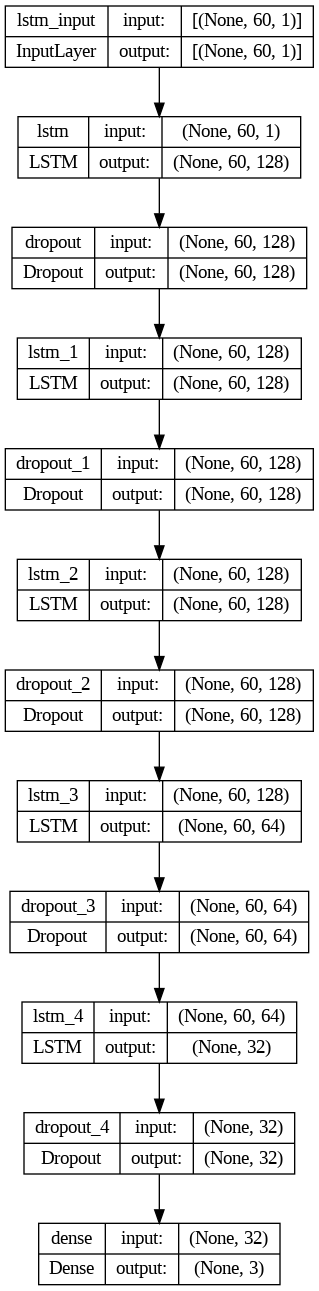

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(model_lstm, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

In [ ]:
# Khởi tạo EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, min_delta=0.0001)

# Khởi tạo ModelCheckpoint callback để lưu mô hình tốt nhất
model_checkpoint = ModelCheckpoint("best_LstmModel_2024.h5", monitor='val_loss', save_best_only=True)

# Huấn luyện mô hình với early stopping và lưu model tốt nhất
history = model_lstm.fit(X_train_lstm, y_train_lstm, epochs=500, batch_size=64,
                          validation_data=(X_test_lstm, y_test_lstm), verbose=1,
                          callbacks=[early_stopping, model_checkpoint])

Epoch 1/500
27/27 [==============================] - 46s 1s/step - loss: 0.0205 - val_loss: 0.0024
Epoch 2/500


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



27/27 [==============================] - 15s 556ms/step - loss: 0.0071 - val_loss: 0.0017
Epoch 3/500
27/27 [==============================] - 15s 547ms/step - loss: 0.0073 - val_loss: 0.0025
Epoch 4/500
27/27 [==============================] - 15s 545ms/step - loss: 0.0053 - val_loss: 0.0017
Epoch 5/500
27/27 [==============================] - 15s 560ms/step - loss: 0.0055 - val_loss: 0.0019
Epoch 6/500
27/27 [==============================] - 15s 546ms/step - loss: 0.0048 - val_loss: 0.0025
Epoch 7/500
27/27 [==============================] - 15s 553ms/step - loss: 0.0057 - val_loss: 0.0025
Epoch 8/500
27/27 [==============================] - 16s 591ms/step - loss: 0.0051 - val_loss: 0.0029
Epoch 9/500
27/27 [==============================] - 17s 640ms/step - loss: 0.0049 - val_loss: 0.0019
Epoch 10/500
27/27 [==============================] - 15s 550ms/step - loss: 0.0046 - val_loss: 0.0021
Epoch 11/500
27/27 [==============================] - 15s 551ms/step - loss: 0.0041 - val_los

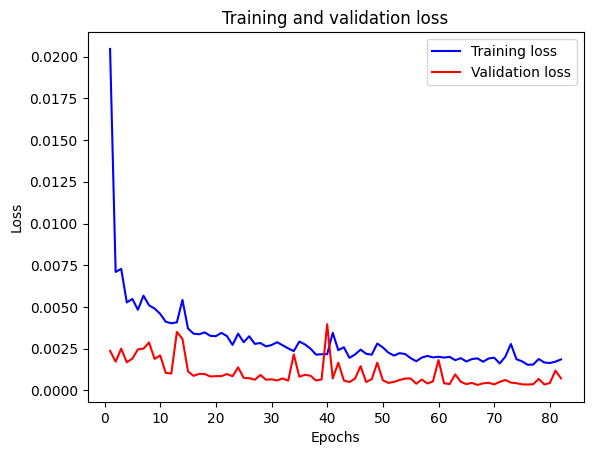

In [ ]:
# Lấy thông tin về loss trên tập huấn luyện và tập validation từ lịch sử huấn luyện
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Vẽ đồ thị biểu diễn sự biến thiên của loss trên tập huấn luyện và tập validation qua các epoch
epochs = range(1, len(train_loss) + 1)
plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Lấy giá trị best train loss và val loss từ EarlyStopping callback
best_train_loss = early_stopping.best
best_val_loss = model_checkpoint.best
# giá trị best train loss và val loss
print("Best train loss:", best_train_loss)
print("Best validation loss:", best_val_loss)

Best train loss: 0.0003838982083834708
Best validation loss: 0.0003314170753583312


#predict

In [ ]:
# Sử dụng mô hình để dự đoán trên tập kiểm tra
predictions = model_lstm.predict(X_test_lstm)

# In ra kết quả dự đoán
print(predictions)
print(predictions.shape)

17/17 [==============================] - 2s 110ms/step
[[0.26146194 0.26166782 0.26593423]
 [0.2578804  0.25814125 0.26227653]
 [0.25499928 0.25528425 0.25935745]
 ...
 [0.7685585  0.76341826 0.7700913 ]
 [0.78686    0.7814147  0.787801  ]
 [0.79383165 0.78825    0.7940306 ]]
(517, 3)


In [ ]:
# load scaler
scaler = joblib.load('min_max_scaler.pkl')

In [ ]:
# Chuẩn hóa lại kết quả dự đoán về dạng ban đầu
original_predictions = scaler.inverse_transform(predictions)

# In ra kết quả dự đoán đã được chuẩn hóa lại về dạng ban đầu
print(original_predictions)
print(original_predictions.shape)

[[1320.4426 1321.416  1341.5867]
 [1303.5099 1304.7432 1324.2938]
 [1289.8887 1291.2358 1310.493 ]
 ...
 [3717.883  3693.581  3725.1296]
 [3804.4084 3778.6643 3808.8574]
 [3837.369  3810.9802 3838.3096]]
(517, 3)


In [ ]:
original_y_test_lstm = scaler.inverse_transform(y_test_lstm)

print(original_y_test_lstm)
print(original_y_test_lstm.shape)

[[1279.57568359 1294.90637207 1288.12390137]
 [1294.90637207 1288.12390137 1297.42211914]
 [1288.12390137 1297.42211914 1274.8717041 ]
 ...
 [3892.06103516 3915.41894531 3881.19311523]
 [3915.41894531 3881.19311523 4066.44506836]
 [3881.19311523 4066.44506836 3980.27319336]]
(517, 3)


In [ ]:
# from sklearn.metrics import mean_squared_error, mean_absolute_error

# Chuyển original_predictions và original_y_test_lstm về dạng mảng 1 chiều
predictions_flat = original_predictions.flatten()
y_test_flat = original_y_test_lstm.flatten()

# Tính RMSE
rmse = mean_squared_error(y_test_flat, predictions_flat, squared=False)

# Tính MSE
mse = mean_squared_error(y_test_flat, predictions_flat)

# Tính MAE
mae = mean_absolute_error(y_test_flat, predictions_flat)

# In kết quả
print("RMSE:", rmse)
print("MSE:", mse)
print("MAE:", mae)


RMSE: 92.63290284375854
MSE: 8580.854689261208
MAE: 64.2373687527704


RMSE (Root Mean Squared Error):
RMSE đo độ lớn trung bình của các sai số dự đoán so với giá trị thực tế.
Nó là căn bậc hai của MSE và thường được ưa chuộng vì nó đánh giá cả sai số lớn hơn một cách cân nhắc hơn so với MSE.
Công thức: RMSE = sqrt(MSE)

MSE (Mean Squared Error):
MSE tính toán trung bình của bình phương của các sai số dự đoán so với giá trị thực tế.
Nó đánh giá các sai số lớn hơn một cách nhất quán.
Công thức: MSE = mean((y_true - y_pred) ** 2)

MAE (Mean Absolute Error):
MAE tính toán trung bình của giá trị tuyệt đối của các sai số dự đoán so với giá trị thực tế.
Nó cũng đánh giá sự chênh lệch trung bình giữa dự đoán và giá trị thực tế, nhưng nó không quan tâm đến hướng của sai số.
Công thức: MAE = mean(abs(y_true - y_pred))

đây là sai số trên cả 3 dự đoán nên sẽ có phần hơi  cao

```
RMSE: 92.63 ~ tương đương với độ lệch $$ khi dự đoán
```



In [ ]:
import pandas as pd
from datetime import timedelta

# Tạo DataFrame cho Prediction_d1
df_prediction_d1 = pd.DataFrame(original_predictions[:, 0], columns=['Prediction_d1'])

# Tạo DataFrame cho Prediction_d2
df_prediction_d2 = pd.DataFrame(original_predictions[:, 1], columns=['Prediction_d2'])

# Tạo DataFrame cho Prediction_d3
df_prediction_d3 = pd.DataFrame(original_predictions[:, 2], columns=['Prediction_d3'])

# Tạo một list các ngày bắt đầu từ tập kiểm tra
test_dates = data.index[-len(y_test_lstm):]

# Thêm cột Date cho từng DataFrame
df_prediction_d1['Date'] = test_dates
df_prediction_d2['Date'] = test_dates + timedelta(days=1)
df_prediction_d3['Date'] = test_dates + timedelta(days=2)

# In ra các bảng mới
print("Prediction_d1")
print(df_prediction_d1)

print("\nPrediction_d2")
print(df_prediction_d2)

print("\nPrediction_d3")
print(df_prediction_d3)


Prediction_d1
     Prediction_d1       Date
0      1320.442627 2022-10-13
1      1303.509888 2022-10-14
2      1289.888672 2022-10-15
3      1282.286499 2022-10-16
4      1281.181519 2022-10-17
..             ...        ...
512    3510.119629 2024-03-08
513    3601.662598 2024-03-09
514    3717.883057 2024-03-10
515    3804.408447 2024-03-11
516    3837.368896 2024-03-12

[517 rows x 2 columns]

Prediction_d2
     Prediction_d2       Date
0      1321.416016 2022-10-14
1      1304.743164 2022-10-15
2      1291.235840 2022-10-16
3      1283.608765 2022-10-17
4      1282.387451 2022-10-18
..             ...        ...
512    3489.283936 2024-03-09
513    3579.278320 2024-03-10
514    3693.581055 2024-03-11
515    3778.664307 2024-03-12
516    3810.980225 2024-03-13

[517 rows x 2 columns]

Prediction_d3
     Prediction_d3       Date
0      1341.586670 2022-10-15
1      1324.293823 2022-10-16
2      1310.493042 2022-10-17
3      1302.920166 2022-10-18
4      1302.018433 2022-10-19
..      

In [ ]:
import plotly.graph_objects as go

# Tạo biểu đồ
fig = go.Figure()

# Plot dữ liệu gốc
fig.add_trace(go.Scatter(x=data.index, y=data['Close'], name='Original Data'))

# Plot dữ liệu Prediction_d1
fig.add_trace(go.Scatter(x=df_prediction_d1['Date'], y=df_prediction_d1['Prediction_d1'], line=dict(color='yellow'), name='Prediction_d1'))

# Plot dữ liệu Prediction_d2
fig.add_trace(go.Scatter(x=df_prediction_d2['Date'], y=df_prediction_d2['Prediction_d2'], line=dict(color='green'), name='Prediction_d2'))

# Plot dữ liệu Prediction_d3
fig.add_trace(go.Scatter(x=df_prediction_d3['Date'], y=df_prediction_d3['Prediction_d3'], line=dict(color='red'), name='Prediction_d3'))

# Cập nhật layout của biểu đồ
fig.update_layout(title='ETH Price Prediction', xaxis_title='Date', yaxis_title='Price')

# Hiển thị biểu đồ
fig.show()


#realtime

In [ ]:
from datetime import datetime, timedelta
import yfinance as yf

# Xác định ký hiệu mã cổ phiếu và phạm vi ngày
stock_symbol = "ETH-USD"

# Lấy ngày hiện tại
end_date = datetime.today().strftime('%Y-%m-%d')

# Lấy ngày 60 ngày trước
start_date = (datetime.today() - timedelta(days=61)).strftime('%Y-%m-%d')

# Lấy dữ liệu lịch sử giá Ethereum từ 60 ngày trước đến ngày hiện tại
ETH = yf.download(stock_symbol, start=start_date, end=end_date)
ETH_realtime = ETH[['Close']]

# Hiển thị dữ liệu gần nhất
print(ETH_realtime.tail())
print(ETH_realtime.shape)


[*********************100%%**********************]  1 of 1 completed

                  Close
Date                   
2024-03-08  3892.061035
2024-03-09  3915.418945
2024-03-10  3881.193115
2024-03-11  4066.445068
2024-03-12  3980.273193
(60, 1)


In [ ]:
# Chuẩn hóa dữ liệu
data_normalized = scaler.transform(ETH_realtime.values)

In [ ]:
# Chuẩn bị dữ liệu cho model
X_test = []
X_test.append(data_normalized[-60:, 0])
X_test = np.array(X_test)

In [ ]:
from tensorflow.keras.models import load_model

# Đường dẫn tới tệp model
model_path = "/content/best_LstmModel_2024.h5"

# Tải model từ tệp
model = load_model(model_path)

In [ ]:
# Dự đoán giá cho 3 ngày tiếp theo
predicted_prices = model.predict(X_test)

1/1 [==============================] - 2s 2s/step


In [ ]:
# In ra dự đoán
print("Predicted prices for the next 3 days:")
print(predicted_prices)

Predicted prices for the next 3 days:
[[0.82975113 0.8275362  0.82726634]]


In [ ]:
# Sử dụng bộ chuẩn hóa đã được lưu
scaler = joblib.load('min_max_scaler.pkl')

# Chuẩn hóa lại predicted_prices
predicted_prices_scaled = scaler.inverse_transform(predicted_prices.reshape(-1, 1)).ravel()

In [ ]:
predicted_prices_scaled

array([4007.1882, 3996.7168, 3995.4407], dtype=float32)

In [ ]:
import pandas as pd

# Tạo DataFrame từ predicted_prices_scaled
predicted_prices  = predicted_prices_scaled

# Ngày cuối cùng trong ETH_realtime
last_date = ETH_realtime.index[-1]

# Tạo một list các ngày mới bắt đầu từ ngày cuối cùng và sau đó 1 ngày
dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=len(predicted_prices))

# Tạo DataFrame từ dữ liệu dự đoán và ngày tương ứng
df_predicted_prices = pd.DataFrame({'Prediction': predicted_prices, 'Date': dates})

print("Dự đoán giá cho 3 ngày tiếp theo: ")
print(df_predicted_prices)

Dự đoán giá cho 3 ngày tiếp theo: 
    Prediction       Date
0  4007.188232 2024-03-13
1  3996.716797 2024-03-14
2  3995.440674 2024-03-15


In [ ]:
# # Thiết lập cột Date làm chỉ mục
# df_predicted_prices.set_index('Date', inplace=True)

# print(df_predicted_prices)